In [122]:
from typing import *
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()


In [123]:
# Since I did not log prefill_length, calculate here
from llminference import repetition
from llminference.eval_adapter import Adapter

data = repetition.Shakespeare.data()
n_samples = 500
examples = [data[i] for i in range(n_samples)]
prefills = [x["context"] + "\n" + x["prompt"] for x in examples]
adapter = Adapter.from_pretrained("EleutherAI/pythia-70m")
prefill_lens = [len(adapter.tok_encode(x)) for x in prefills]
prefill_length = sum(prefill_lens) / len(prefill_lens)
print(f"Average prefill length for the first {n_samples} examples: {prefill_length:.2f}")


Average prefill length for the first 500 examples: 1868.95


In [124]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        mc = run.summary["model_config"] if "model_config" in run.summary else {}
        sparsity = run.config["sparsity"]
        # if "score" in sparsity:
        #     score = sparsity.pop("score")
        #     sparsity["ann_score"] = score.pop("name")
        #     sparsity.update(score)
        return dict(
            model_scale=run.config["model"].replace("EleutherAI/pythia-", ""),
            sparsity=sparsity["name"],
            k=sparsity["k"] if "k" in sparsity else None,
            rank=sparsity["score"]["rank"] if "score" in sparsity else None,
            n_heads=mc["num_attention_heads"],
            head_size=mc["hidden_size"] // mc["num_attention_heads"],
            prefill_length=1869,  # did not log
            match_length_char=run.summary["match_length"],
            reference_length_char=run.summary["reference_length"]
        )


def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(
        filter(
            None,
            (
                load_one(run)
                for run in api.runs(
                    "research/sparse-attention",
                    {
                        "$or": [
                            {"config.name": experiment_name},
                            *({"display_name": n} for n in single_runs),
                        ]
                    },
                )
            ),
        )
    )


def memory_transfers_attention_only(
    s: pd.Series, count_kv: bool = True, count_index: bool = True
) -> int:
    kv_elements, index_elements = 0, 0
    if s["sparsity"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"] * s["n_heads"]

    elif s["sparsity"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"] * s["n_heads"]

    elif s["sparsity"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"] * s["n_heads"]
        # read/write scores
        index_elements = 1 + 2 * s["prefill_length"]

    elif s["sparsity"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"] * s["n_heads"]
        # write index
        index_elements += s["head_size"] * s["n_heads"]
        # read index
        index_elements += s["prefill_length"] * s["rank"] * s["n_heads"]

    else:
        assert False, s["name"]

    return count_kv * kv_elements + count_index * index_elements


def technique(s: pd.Series) -> str:
    return "_".join(
        str(n) for n in [s["name"], s["strategy"], s["ann_score"]] if not pd.isna(n)
    )


df = (
    load_sweep("RMOE-62-repetition-task-test")
    .pipe(
        lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1))
    )
    .pipe(
        lambda d: d.assign(
            index_transfers=d.apply(
                partial(memory_transfers_attention_only, count_kv=False), axis=1
            )
        )
    )
)[["model_scale", "sparsity", "k", "rank", "match_length_char", "reference_length_char", "transfers"]]
# Only plot the rank = 32 points (only explored ranks for k = 32, should explore different ranks for k >= 64)
df = df[df["rank"].isna() | (df["rank"] == 32)]
df.head()


,model_scale,sparsity,k,rank,match_length_char,reference_length_char,transfers
9,2.8b,ann,512.0,32.0,160.582,258.506,4542976.0
10,2.8b,eviction,512.0,NaN,22.296,258.506,2630299.0
11,2.8b,sparse_v,512.0,NaN,160.130,258.506,6100480.0
12,2.8b,ann,256.0,32.0,160.736,258.506,3232256.0
13,2.8b,eviction,256.0,NaN,14.076,258.506,1319579.0


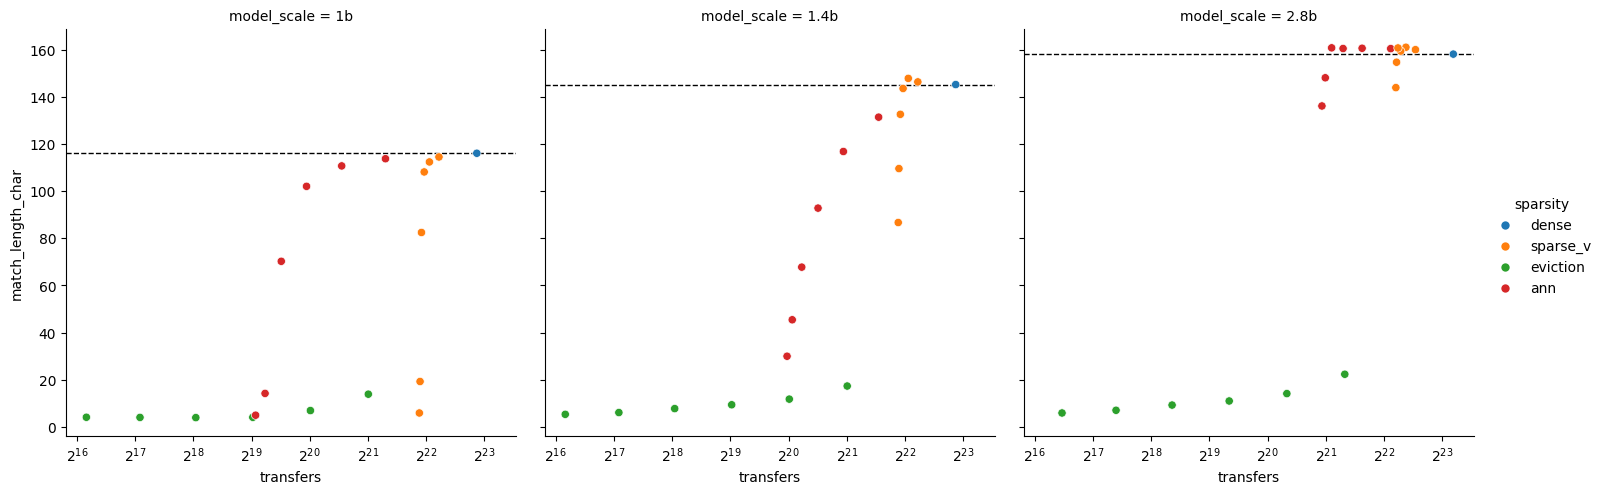

In [125]:
model_scales = ["1b", "1.4b", "2.8b"]
p = sns.relplot(
    data=df,
    x="transfers",
    y="match_length_char",
    hue="sparsity",
    hue_order=["dense", "sparse_v", "eviction", "ann"],
    col="model_scale",
    col_order=model_scales,
)
plt.xscale("log", base=2)
for ax, m in zip(p.axes[0], model_scales):
    dense = df[(df["model_scale"] == m) & (df["sparsity"] == "dense")][
        "match_length_char"
    ].item()
    ax.axhline(y=dense, color="black", linestyle="--", linewidth=1, zorder=0)
